##### 請把心電圖資料集分成訓練、驗證以及測試資料集，並且轉成灰階圖片，再完成以下題目

## 第一題

### part1(LEAD_I)

#### 1.根據所被分配到的模型，使用transfer_learning並且連接分類器(架構自己設定)，訓練LEAD_I資料集，accuracy需達80%以上

In [ ]:
# 讀取 LEAD_I 資料集

from google.colab import drive
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.optimizers import SGD

# Mount Google Drive
drive.mount('/content/drive')

# Access files "LEAD_I_output_classes_removed_border"
dataset_folder = '/content/drive/My Drive/Colab Notebooks/LEAD_I_output_classes_removed_border'

batch_size = 32
img_size = (180, 180)
img_shape = (180, 180, 3)


Mounted at /content/drive


In [ ]:
# 資料前處理
def preprocess_image(image_path):
    # Load image in grayscale and resize
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    img = np.expand_dims(img, axis=-1)  # Expand dimensions to make it (180, 180, 1)
    img = img / 255.0  # Normalize
    return img

# Custom data generator for grayscale images
class GrayImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def preprocess_image(self, image):
        return preprocess_image(image)

In [ ]:
# 產生 train_generator, validation_test_generator, validation_generator, test_generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    subset='training'
)

validation_test_generator = datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    subset='validation'
)

# Split the validation set into validation and test sets
validation_images, test_images, validation_labels, test_labels = train_test_split(
    validation_test_generator.filenames,
    validation_test_generator.labels,
    test_size=0.5,
    random_state=42
)

validation_df = pd.DataFrame({"filename": validation_images, "category": validation_labels.astype(str)})
test_df = pd.DataFrame({"filename": test_images, "category": test_labels.astype(str)})

validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    x_col="filename",
    y_col="category"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    x_col="filename",
    y_col="category"
)


Found 10259 images belonging to 11 classes.
Found 2560 images belonging to 11 classes.
Found 1280 validated image filenames belonging to 11 classes.
Found 1280 validated image filenames belonging to 11 classes.


In [ ]:
# 定義 model
import keras
from keras.layers import Input, Concatenate
from keras.models import Model

vgg16_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    # input_tensor=expanded_input
    input_shape=(180, 180, 3)
)
# vgg16_base.summary()

from keras.layers import Activation, Dense
from keras import layers
import tensorflow as tf


x = vgg16_base.output
x = layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output_layer = layers.Dense(units = 11, activation = 'softmax')(x)

# # freeze the weight
# base_model.trainable = False

model = tf.keras.Model(inputs = vgg16_base.input, outputs = output_layer)
for layer in vgg16_base.layers:
  layer.trainable=False

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [ ]:
# Compile model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# 在這之前已歷經 50 個 epoch 的 training，但 accuracy 仍只有 0.7984，因此再進行 15 個 epoch 的 training。 準確率達到 0.8363
epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
321/321 [==============================] - 94s 292ms/step - loss: 0.5435 - accuracy: 0.7994 - val_loss: 3.9241 - val_accuracy: 0.2371
Epoch 2/15
321/321 [==============================] - 75s 233ms/step - loss: 0.5282 - accuracy: 0.8058 - val_loss: 4.4268 - val_accuracy: 0.2496
Epoch 3/15
321/321 [==============================] - 79s 246ms/step - loss: 0.5176 - accuracy: 0.8113 - val_loss: 4.3586 - val_accuracy: 0.2316
Epoch 4/15
321/321 [==============================] - 84s 261ms/step - loss: 0.5184 - accuracy: 0.8039 - val_loss: 4.5948 - val_accuracy: 0.2316
Epoch 5/15
321/321 [==============================] - 75s 235ms/step - loss: 0.5112 - accuracy: 0.8121 - val_loss: 4.5326 - val_accuracy: 0.2152
Epoch 6/15
321/321 [==============================] - 75s 232ms/step - loss: 0.4939 - accuracy: 0.8217 - val_loss: 4.6641 - val_accuracy: 0.2363
Epoch 7/15
321/321 [==============================] - 75s 234ms/step - loss: 0.4868 - accuracy: 0.8235 - val_loss: 4.4101 - val_ac

#### 2.根據第一小題的結果，使用兩種不同的optimizer比較哪一種對於辨識效果比較好

In [ ]:
## RMSprop, learning_rate=0.0015, 15 個 epoch -> accuracy = 0.6091
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
321/321 [==============================] - 3101s 10s/step - loss: 1.7370 - accuracy: 0.3561 - val_loss: 2.4809 - val_accuracy: 0.2562
Epoch 2/15
321/321 [==============================] - 75s 234ms/step - loss: 1.5294 - accuracy: 0.4410 - val_loss: 2.9744 - val_accuracy: 0.2313
Epoch 3/15
321/321 [==============================] - 74s 230ms/step - loss: 1.4531 - accuracy: 0.4625 - val_loss: 2.7425 - val_accuracy: 0.2500
Epoch 4/15
321/321 [==============================] - 74s 230ms/step - loss: 1.3971 - accuracy: 0.4827 - val_loss: 3.2237 - val_accuracy: 0.2414
Epoch 5/15
321/321 [==============================] - 75s 233ms/step - loss: 1.3530 - accuracy: 0.5033 - val_loss: 2.4983 - val_accuracy: 0.2648
Epoch 6/15
321/321 [==============================] - 74s 230ms/step - loss: 1.3098 - accuracy: 0.5124 - val_loss: 2.7182 - val_accuracy: 0.1984
Epoch 7/15
321/321 [==============================] - 74s 232ms/step - loss: 1.2681 - accuracy: 0.5314 - val_loss: 2.6705 - val_ac

In [ ]:
## SGD, learning_rate=0.0015, 15個 epoch -> accuracy = 0.3662
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
321/321 [==============================] - 90s 277ms/step - loss: 1.9209 - accuracy: 0.2645 - val_loss: 2.4471 - val_accuracy: 0.1117
Epoch 2/15
321/321 [==============================] - 74s 230ms/step - loss: 1.8582 - accuracy: 0.2855 - val_loss: 2.4656 - val_accuracy: 0.0688
Epoch 3/15
321/321 [==============================] - 74s 229ms/step - loss: 1.8470 - accuracy: 0.2958 - val_loss: 2.4237 - val_accuracy: 0.1203
Epoch 4/15
321/321 [==============================] - 74s 232ms/step - loss: 1.8396 - accuracy: 0.3133 - val_loss: 2.4715 - val_accuracy: 0.0922
Epoch 5/15
321/321 [==============================] - 74s 231ms/step - loss: 1.8323 - accuracy: 0.3179 - val_loss: 2.4671 - val_accuracy: 0.1688
Epoch 6/15
321/321 [==============================] - 74s 230ms/step - loss: 1.8258 - accuracy: 0.3248 - val_loss: 2.4145 - val_accuracy: 0.2031
Epoch 7/15
321/321 [==============================] - 73s 229ms/step - loss: 1.8195 - accuracy: 0.3358 - val_loss: 2.4198 - val_ac

#### 3.根據第二小題的結果，取用較好結果的優化器，並且改變learning_rate，說明嘗試過的數值，哪一個對於辨識效果比較好

根據結果，選用 RMSprop。

In [ ]:
## RMSprop, Learning_rate = 0.1 -> accuracy = 0.2394
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)


Epoch 1/30
321/321 [==============================] - 91s 279ms/step - loss: 7.0279 - accuracy: 0.2337 - val_loss: 2.5373 - val_accuracy: 0.1937
Epoch 2/30
321/321 [==============================] - 74s 229ms/step - loss: 1.8872 - accuracy: 0.2431 - val_loss: 2.5491 - val_accuracy: 0.2148
Epoch 3/30
321/321 [==============================] - 74s 230ms/step - loss: 1.8873 - accuracy: 0.2406 - val_loss: 2.5506 - val_accuracy: 0.0562
Epoch 4/30
321/321 [==============================] - 73s 227ms/step - loss: 1.8871 - accuracy: 0.2434 - val_loss: 2.5952 - val_accuracy: 0.0562
Epoch 5/30
321/321 [==============================] - 75s 235ms/step - loss: 1.8873 - accuracy: 0.2395 - val_loss: 2.4426 - val_accuracy: 0.1937
Epoch 6/30
321/321 [==============================] - 73s 228ms/step - loss: 1.8882 - accuracy: 0.2420 - val_loss: 2.4985 - val_accuracy: 0.0562
Epoch 7/30
321/321 [==============================] - 76s 238ms/step - loss: 1.8877 - accuracy: 0.2400 - val_loss: 2.5141 - val_ac

In [ ]:
## RMSprop, Learning_rate = 0.01 -> accuracy: 0.5900

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/30
321/321 [==============================] - 75s 230ms/step - loss: 1.8474 - accuracy: 0.3486 - val_loss: 2.5424 - val_accuracy: 0.2398
Epoch 2/30
321/321 [==============================] - 76s 238ms/step - loss: 1.5450 - accuracy: 0.4305 - val_loss: 2.8259 - val_accuracy: 0.2414
Epoch 3/30
321/321 [==============================] - 73s 226ms/step - loss: 1.4642 - accuracy: 0.4611 - val_loss: 2.9469 - val_accuracy: 0.2414
Epoch 4/30
321/321 [==============================] - 73s 226ms/step - loss: 1.4209 - accuracy: 0.4756 - val_loss: 3.0476 - val_accuracy: 0.2406
Epoch 5/30
321/321 [==============================] - 74s 231ms/step - loss: 1.3825 - accuracy: 0.4923 - val_loss: 3.3154 - val_accuracy: 0.2391
Epoch 6/30
321/321 [==============================] - 74s 231ms/step - loss: 1.3594 - accuracy: 0.4994 - val_loss: 2.8839 - val_accuracy: 0.2539
Epoch 7/30
321/321 [==============================] - 72s 225ms/step - loss: 1.3232 - accuracy: 0.5095 - val_loss: 3.3538 - val_ac

In [ ]:
## RMSprop, Learning_rate = 0.001 -> accuracy: 0.6881

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/30
321/321 [==============================] - 74s 228ms/step - loss: 1.7384 - accuracy: 0.3571 - val_loss: 2.5265 - val_accuracy: 0.2539
Epoch 2/30
321/321 [==============================] - 73s 228ms/step - loss: 1.5380 - accuracy: 0.4409 - val_loss: 2.4607 - val_accuracy: 0.2711
Epoch 3/30
321/321 [==============================] - 73s 228ms/step - loss: 1.4511 - accuracy: 0.4659 - val_loss: 2.2822 - val_accuracy: 0.2750
Epoch 4/30
321/321 [==============================] - 73s 226ms/step - loss: 1.3931 - accuracy: 0.4945 - val_loss: 2.4392 - val_accuracy: 0.2453
Epoch 5/30
321/321 [==============================] - 73s 226ms/step - loss: 1.3539 - accuracy: 0.4989 - val_loss: 2.4916 - val_accuracy: 0.2211
Epoch 6/30
321/321 [==============================] - 73s 228ms/step - loss: 1.3031 - accuracy: 0.5170 - val_loss: 2.6119 - val_accuracy: 0.2484
Epoch 7/30
321/321 [==============================] - 75s 235ms/step - loss: 1.2703 - accuracy: 0.5319 - val_loss: 2.5724 - val_ac

In [ ]:
## RMSprop, Learning_rate = 0.0001 -> accuracy: 0.5490

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/30
321/321 [==============================] - 75s 230ms/step - loss: 1.8273 - accuracy: 0.3233 - val_loss: 2.4343 - val_accuracy: 0.2156
Epoch 2/30
321/321 [==============================] - 73s 228ms/step - loss: 1.7347 - accuracy: 0.3825 - val_loss: 2.4173 - val_accuracy: 0.2180
Epoch 3/30
321/321 [==============================] - 71s 221ms/step - loss: 1.6818 - accuracy: 0.4121 - val_loss: 2.4393 - val_accuracy: 0.2305
Epoch 4/30
321/321 [==============================] - 72s 223ms/step - loss: 1.6391 - accuracy: 0.4299 - val_loss: 2.3536 - val_accuracy: 0.2266
Epoch 5/30
321/321 [==============================] - 73s 227ms/step - loss: 1.6013 - accuracy: 0.4402 - val_loss: 2.4602 - val_accuracy: 0.2133
Epoch 6/30
321/321 [==============================] - 71s 222ms/step - loss: 1.5689 - accuracy: 0.4567 - val_loss: 2.3754 - val_accuracy: 0.2398
Epoch 7/30
321/321 [==============================] - 71s 222ms/step - loss: 1.5391 - accuracy: 0.4679 - val_loss: 2.4157 - val_ac

結果：Learning_rate = 0.001 時, accuracy 最高


#### 4.根據以上小題，將較好的結果畫出loss_curve、accuracy_curve、confusion_matrix及Classification_report


In [ ]:
## RMSprop, Learning_rate = 0.001, epochs = 90

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=90
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/90
321/321 [==============================] - 2520s 8s/step - loss: 1.7360 - accuracy: 0.3613 - val_loss: 2.7643 - val_accuracy: 0.1844
Epoch 2/90
321/321 [==============================] - 74s 231ms/step - loss: 1.5394 - accuracy: 0.4353 - val_loss: 2.6047 - val_accuracy: 0.2313
Epoch 3/90
321/321 [==============================] - 74s 231ms/step - loss: 1.4521 - accuracy: 0.4672 - val_loss: 2.9060 - val_accuracy: 0.2383
Epoch 4/90
321/321 [==============================] - 74s 231ms/step - loss: 1.3963 - accuracy: 0.4817 - val_loss: 2.7786 - val_accuracy: 0.2609
Epoch 5/90
321/321 [==============================] - 74s 230ms/step - loss: 1.3468 - accuracy: 0.5064 - val_loss: 2.6944 - val_accuracy: 0.2555
Epoch 6/90
321/321 [==============================] - 72s 225ms/step - loss: 1.3090 - accuracy: 0.5188 - val_loss: 2.5504 - val_accuracy: 0.2445
Epoch 7/90
321/321 [==============================] - 73s 226ms/step - loss: 1.2717 - accuracy: 0.5309 - val_loss: 2.7637 - val_acc

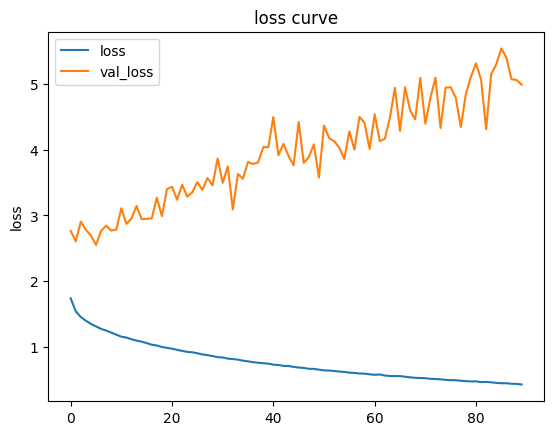

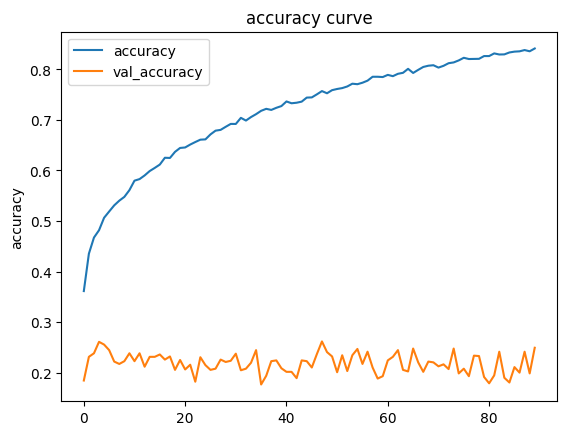

In [ ]:
# 畫出 loss_curve、accuracy_curve
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

40/40 [==============================] - 293s 8s/step


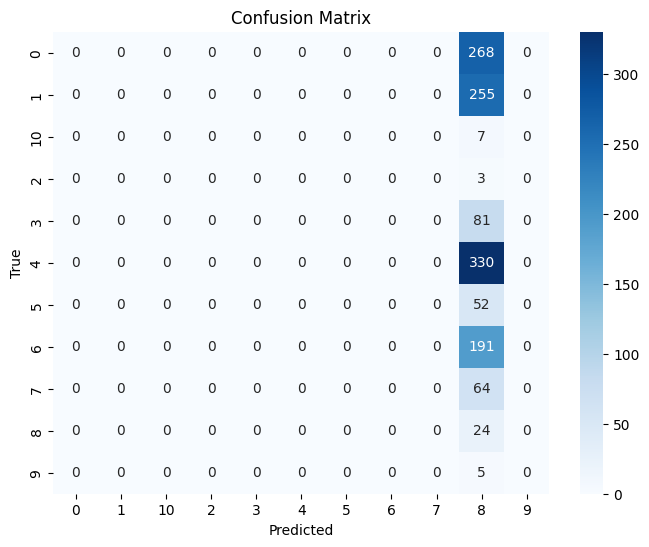

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       268
           1       0.00      0.00      0.00       255
          10       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00        81
           4       0.00      0.00      0.00       330
           5       0.00      0.00      0.00        52
           6       0.00      0.00      0.00       191
           7       0.00      0.00      0.00        64
           8       0.02      1.00      0.04        24
           9       0.00      0.00      0.00         5

    accuracy                           0.02      1280
   macro avg       0.00      0.09      0.00      1280
weighted avg       0.00      0.02      0.00      1280



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 畫出 confusion_matrix及Classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Predict test set
test_predictions = model.predict(test_generator)
# Convert predictions to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices))


#### 5.(加分題)嘗試data_augmentation，比較結果是否變差或變好


In [123]:
# 讀取 LEAD_I 資料集 並做 data_augmentation
# 資料前處理
# 產生 train_generator, validation_test_generator, validation_generator, test_generator
# 定義 model

from google.colab import drive
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Mount Google Drive
drive.mount('/content/drive')

# Access files "LEAD_I_output_classes_removed_border"
dataset_folder = '/content/drive/My Drive/Colab Notebooks/LEAD_I_output_classes_removed_border'

batch_size = 32
img_size = (180, 180)
img_shape = (180, 180, 3)

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Degree range for random rotations
    width_shift_range=0.2,  # Fraction of total width for random horizontal shifts
    height_shift_range=0.2,  # Fraction of total height for random vertical shifts
    shear_range=0.2,  # Shear angle in counter-clockwise direction
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    validation_split=0.2
)

# Create a data generator for training with augmentation
train_generator = train_datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    subset='training'
)

# Data generators for validation and test sets
validation_test_generator = train_datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    subset='validation'
)


# Split the validation set into validation and test sets
validation_images, test_images, validation_labels, test_labels = train_test_split(
    validation_test_generator.filenames,
    validation_test_generator.labels,
    test_size=0.5,
    random_state=42
)

validation_df = pd.DataFrame({"filename": validation_images, "category": validation_labels.astype(str)})
test_df = pd.DataFrame({"filename": test_images, "category": test_labels.astype(str)})

validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    x_col="filename",
    y_col="category"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    x_col="filename",
    y_col="category"
)


# Model architecture setup and compilation
vgg16_base = tf.keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

x = vgg16_base.output
x = layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = layers.Dense(units=11, activation='softmax')(x)

model = tf.keras.Model(inputs=vgg16_base.input, outputs=output_layer)

for layer in vgg16_base.layers:
    layer.trainable = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 10259 images belonging to 11 classes.
Found 2560 images belonging to 11 classes.
Found 1280 validated image filenames belonging to 11 classes.
Found 1280 validated image filenames belonging to 11 classes.


In [124]:
# Compile model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 80
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/80
321/321 [==============================] - 153s 469ms/step - loss: 1.8377 - accuracy: 0.3044 - val_loss: 2.7469 - val_accuracy: 0.1461
Epoch 2/80
321/321 [==============================] - 148s 462ms/step - loss: 1.7378 - accuracy: 0.3456 - val_loss: 2.5431 - val_accuracy: 0.2367
Epoch 3/80
321/321 [==============================] - 151s 469ms/step - loss: 1.6969 - accuracy: 0.3598 - val_loss: 2.4929 - val_accuracy: 0.2484
Epoch 4/80
321/321 [==============================] - 149s 464ms/step - loss: 1.6506 - accuracy: 0.3794 - val_loss: 2.6515 - val_accuracy: 0.1875
Epoch 5/80
321/321 [==============================] - 148s 460ms/step - loss: 1.6294 - accuracy: 0.3891 - val_loss: 2.7507 - val_accuracy: 0.2094
Epoch 6/80
321/321 [==============================] - 150s 466ms/step - loss: 1.6077 - accuracy: 0.3984 - val_loss: 2.7058 - val_accuracy: 0.2141
Epoch 7/80
321/321 [==============================] - 145s 453ms/step - loss: 1.5909 - accuracy: 0.4078 - val_loss: 2.7967 -

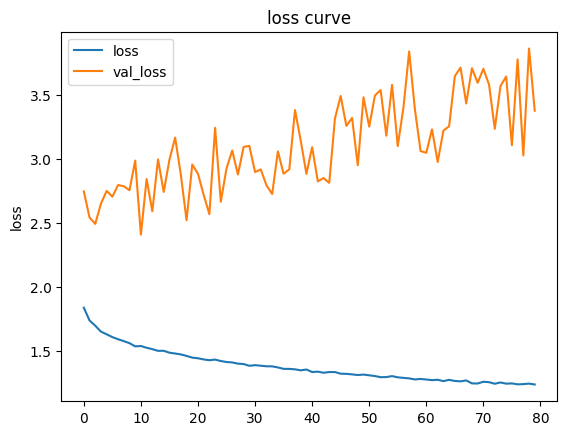

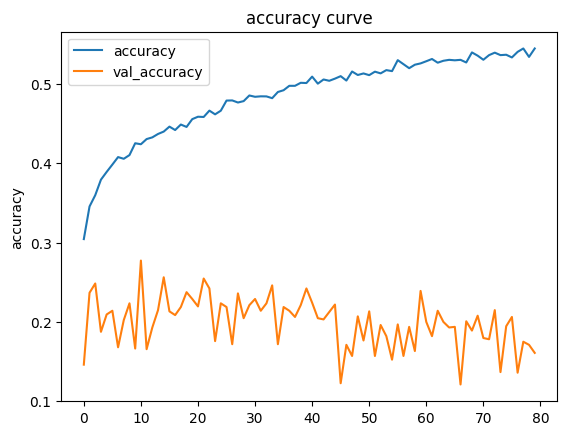

40/40 [==============================] - 8s 185ms/step


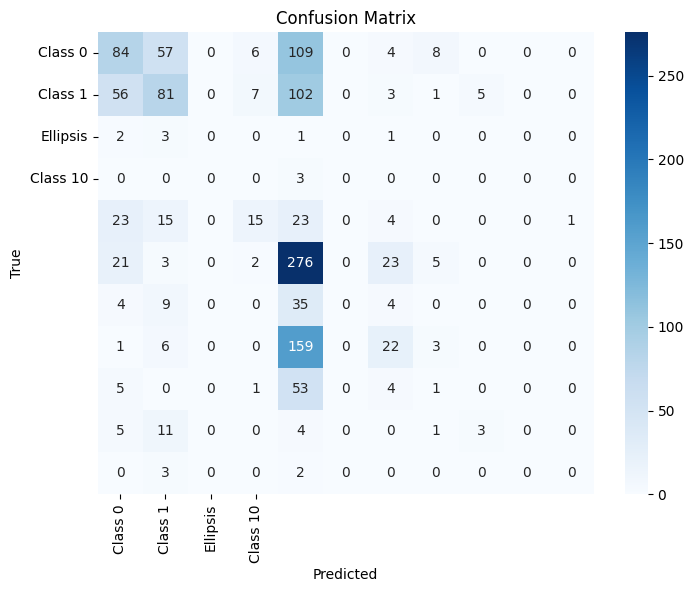

ValueError: ignored

In [125]:
# 畫出 loss_curve、accuracy_curve
# 畫出 confusion_matrix及Classification_report
# 結果變差
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Prediction and evaluation
test_predictions = model.predict(test_generator)
predicted_labels = np.argmax(test_predictions, axis=1)

cm = confusion_matrix(test_generator.classes, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', ..., 'Class 10'], yticklabels=['Class 0', 'Class 1', ..., 'Class 10'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(test_generator.classes, predicted_labels, target_names=['Class 0', 'Class 1', ..., 'Class 10']))


### part2(被分配到的另一個導程)


#### 1.根據所被分配到的模型，以part1第一小題的架構，訓練被分配到的另一個導程資料集

In [ ]:
# 讀取 LEAD_aVF 資料集
from google.colab import drive
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.optimizers import SGD

# Mount Google Drive
drive.mount('/content/drive')

# Access files "LEAD_I_output_classes_removed_border"
dataset_folder = '/content/drive/My Drive/Colab Notebooks/LEAD_aVF_output_classes_removed_border'

batch_size = 32
img_size = (180, 180)
img_shape = (180, 180, 3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 資料前處理
def preprocess_image(image_path):
    # Load image in grayscale and resize
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    img = np.expand_dims(img, axis=-1)  # Expand dimensions to make it (180, 180, 1)
    img = img / 255.0  # Normalize
    return img

# Custom data generator for grayscale images
class GrayImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def preprocess_image(self, image):
        return preprocess_image(image)



In [ ]:
# 產生 train_generator, validation_test_generator, validation_generator, test_generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    subset='training'
)

validation_test_generator = datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    subset='validation'
)

# Split the validation set into validation and test sets
validation_images, test_images, validation_labels, test_labels = train_test_split(
    validation_test_generator.filenames,
    validation_test_generator.labels,
    test_size=0.5,
    random_state=42
)

validation_df = pd.DataFrame({"filename": validation_images, "category": validation_labels.astype(str)})
test_df = pd.DataFrame({"filename": test_images, "category": test_labels.astype(str)})

validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    x_col="filename",
    y_col="category"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    x_col="filename",
    y_col="category"
)

Found 10259 images belonging to 11 classes.
Found 2560 images belonging to 11 classes.
Found 1280 validated image filenames belonging to 11 classes.
Found 1280 validated image filenames belonging to 11 classes.


In [ ]:
# 定義 model
import keras
from keras.layers import Input, Concatenate
from keras.models import Model

vgg16_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    # input_tensor=expanded_input
    input_shape=(180, 180, 3)
)
# vgg16_base.summary()

from keras.layers import Activation, Dense
from keras import layers
import tensorflow as tf


x = vgg16_base.output
x = layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output_layer = layers.Dense(units = 11, activation = 'softmax')(x)

# # freeze the weight
# base_model.trainable = False

model = tf.keras.Model(inputs = vgg16_base.input, outputs = output_layer)
for layer in vgg16_base.layers:
  layer.trainable=False

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [ ]:
# Compile model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# 在此之前已經過 20 個 epoch 的 training ,因重新連線，因此再進行 50 個 epoch 的 training。
epochs=50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/50
321/321 [==============================] - 142s 442ms/step - loss: 1.1750 - accuracy: 0.5749 - val_loss: 2.8697 - val_accuracy: 0.2227
Epoch 2/50
321/321 [==============================] - 72s 224ms/step - loss: 1.1486 - accuracy: 0.5783 - val_loss: 2.6947 - val_accuracy: 0.2484
Epoch 3/50
321/321 [==============================] - 76s 237ms/step - loss: 1.1255 - accuracy: 0.5827 - val_loss: 2.7920 - val_accuracy: 0.2523
Epoch 4/50
321/321 [==============================] - 72s 224ms/step - loss: 1.0873 - accuracy: 0.5986 - val_loss: 2.9799 - val_accuracy: 0.1961
Epoch 5/50
321/321 [==============================] - 75s 232ms/step - loss: 1.0561 - accuracy: 0.6120 - val_loss: 2.8265 - val_accuracy: 0.2289
Epoch 6/50
321/321 [==============================] - 73s 227ms/step - loss: 1.0232 - accuracy: 0.6243 - val_loss: 3.2282 - val_accuracy: 0.2086
Epoch 7/50
321/321 [==============================] - 74s 231ms/step - loss: 1.0154 - accuracy: 0.6258 - val_loss: 3.0685 - val_a

#### 2.使用與part1相同的兩個optimizer，比較哪一種對於辨識效果比較好

In [ ]:
## RMSprop, learning_rate=0.0015, 15個 epoch -> accuracy = 0.6033
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
321/321 [==============================] - 76s 232ms/step - loss: 1.7356 - accuracy: 0.3631 - val_loss: 2.4712 - val_accuracy: 0.2156
Epoch 2/15
321/321 [==============================] - 73s 228ms/step - loss: 1.5320 - accuracy: 0.4375 - val_loss: 2.4566 - val_accuracy: 0.2406
Epoch 3/15
321/321 [==============================] - 74s 231ms/step - loss: 1.4540 - accuracy: 0.4633 - val_loss: 2.6201 - val_accuracy: 0.2031
Epoch 4/15
321/321 [==============================] - 74s 229ms/step - loss: 1.4006 - accuracy: 0.4798 - val_loss: 2.6582 - val_accuracy: 0.1758
Epoch 5/15
321/321 [==============================] - 72s 226ms/step - loss: 1.3422 - accuracy: 0.5004 - val_loss: 2.5911 - val_accuracy: 0.2172
Epoch 6/15
321/321 [==============================] - 72s 225ms/step - loss: 1.3002 - accuracy: 0.5202 - val_loss: 3.4643 - val_accuracy: 0.2234
Epoch 7/15
321/321 [==============================] - 72s 225ms/step - loss: 1.2590 - accuracy: 0.5348 - val_loss: 2.6393 - val_ac

In [ ]:
## SGD, learning_rate=0.0015, 15個 epoch -> accuracy = 0.3678
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
321/321 [==============================] - 79s 238ms/step - loss: 1.9181 - accuracy: 0.2465 - val_loss: 2.4582 - val_accuracy: 0.0617
Epoch 2/15
321/321 [==============================] - 73s 228ms/step - loss: 1.8612 - accuracy: 0.2706 - val_loss: 2.4411 - val_accuracy: 0.2461
Epoch 3/15
321/321 [==============================] - 74s 232ms/step - loss: 1.8518 - accuracy: 0.2834 - val_loss: 2.4553 - val_accuracy: 0.1258
Epoch 4/15
321/321 [==============================] - 74s 230ms/step - loss: 1.8444 - accuracy: 0.2971 - val_loss: 2.4625 - val_accuracy: 0.1031
Epoch 5/15
321/321 [==============================] - 77s 239ms/step - loss: 1.8381 - accuracy: 0.3072 - val_loss: 2.5070 - val_accuracy: 0.0695
Epoch 6/15
321/321 [==============================] - 75s 234ms/step - loss: 1.8310 - accuracy: 0.3171 - val_loss: 2.4394 - val_accuracy: 0.1594
Epoch 7/15
321/321 [==============================] - 82s 254ms/step - loss: 1.8250 - accuracy: 0.3378 - val_loss: 2.4346 - val_ac

#### 3.使用與part1第三小題一樣的optimizer及learning，並畫出loss_curve、accuracy_curve、confusion_matrix及Classification_report

In [ ]:
## RMSprop, Learning_rate = 0.001, epochs = 90

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs=80
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/80
321/321 [==============================] - 76s 236ms/step - loss: 1.5377 - accuracy: 0.4386 - val_loss: 2.5185 - val_accuracy: 0.2438
Epoch 2/80
321/321 [==============================] - 74s 229ms/step - loss: 1.4519 - accuracy: 0.4723 - val_loss: 2.6550 - val_accuracy: 0.2570
Epoch 3/80
321/321 [==============================] - 73s 228ms/step - loss: 1.3984 - accuracy: 0.4862 - val_loss: 2.5384 - val_accuracy: 0.2250
Epoch 4/80
321/321 [==============================] - 74s 230ms/step - loss: 1.3535 - accuracy: 0.5019 - val_loss: 2.3887 - val_accuracy: 0.2594
Epoch 5/80
321/321 [==============================] - 73s 227ms/step - loss: 1.3102 - accuracy: 0.5198 - val_loss: 2.5099 - val_accuracy: 0.2156
Epoch 6/80
321/321 [==============================] - 73s 227ms/step - loss: 1.2721 - accuracy: 0.5288 - val_loss: 2.6526 - val_accuracy: 0.2328
Epoch 7/80
321/321 [==============================] - 74s 229ms/step - loss: 1.2447 - accuracy: 0.5361 - val_loss: 2.7868 - val_ac

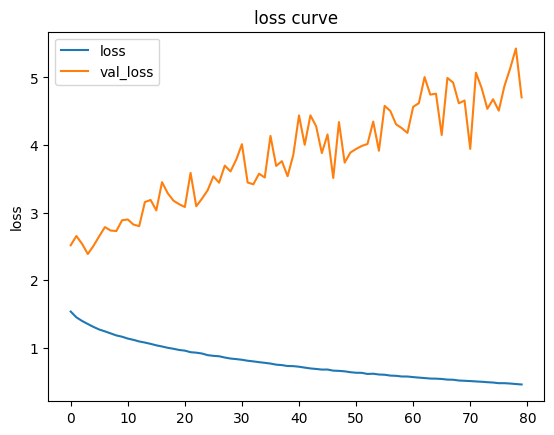

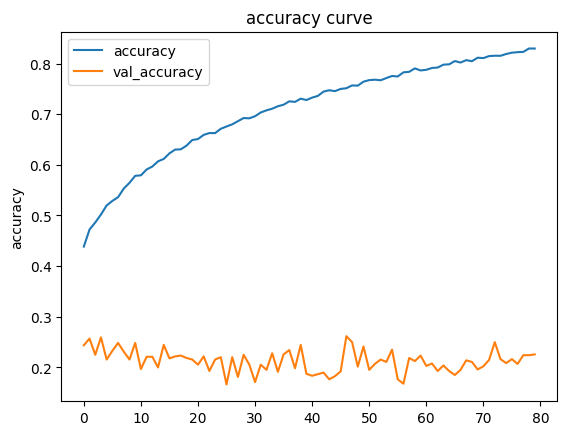

In [ ]:
# 畫出 loss_curve、accuracy_curve
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

40/40 [==============================] - 966s 25s/step


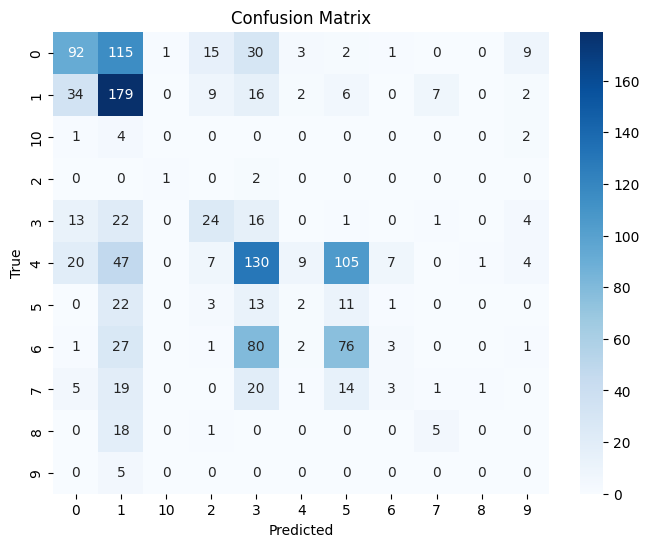

              precision    recall  f1-score   support

           0       0.55      0.34      0.42       268
           1       0.39      0.70      0.50       255
          10       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         3
           3       0.05      0.20      0.08        81
           4       0.47      0.03      0.05       330
           5       0.05      0.21      0.08        52
           6       0.20      0.02      0.03       191
           7       0.07      0.02      0.03        64
           8       0.00      0.00      0.00        24
           9       0.00      0.00      0.00         5

    accuracy                           0.24      1280
   macro avg       0.16      0.14      0.11      1280
weighted avg       0.35      0.24      0.22      1280



In [ ]:
# 畫出 confusion_matrix及Classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Predict test set
test_predictions = model.predict(test_generator)
# Convert predictions to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices))


#### 5.嘗試data_augmentation，比較結果是否變差或變好(加分題)


In [128]:
# 讀取 LEAD_I 資料集
# 資料前處理
# 產生 train_generator, validation_test_generator, validation_generator, test_generator
# 定義 model

from google.colab import drive
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Mount Google Drive
drive.mount('/content/drive')

# Access files "LEAD_I_output_classes_removed_border"
dataset_folder = '/content/drive/My Drive/Colab Notebooks/LEAD_aVF_output_classes_removed_border'

batch_size = 32
img_size = (180, 180)
img_shape = (180, 180, 3)

from sklearn.model_selection import train_test_split

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Create a data generator for training with augmentation
train_generator = train_datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    subset='training'
)

# Data generators for validation and test sets
validation_test_generator = train_datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    subset='validation'
)

# Combine validation and test sets for further splitting
validation_test_images = validation_test_generator.filenames
validation_test_labels = validation_test_generator.classes

# Split the combined validation and test sets into separate sets
validation_images, test_images, validation_labels, test_labels = train_test_split(
    validation_test_images,
    validation_test_labels,
    test_size=0.5,
    random_state=42,
    stratify=validation_test_labels  # Ensures proportional split of classes
)

# Create dataframes for validation and test sets
validation_df = pd.DataFrame({"filename": validation_images, "category": validation_labels.astype(str)})
test_df = pd.DataFrame({"filename": test_images, "category": test_labels.astype(str)})

# Create generators for validation and test sets from dataframes
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    x_col="filename",
    y_col="category"
)

test_generator = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    x_col="filename",
    y_col="category"
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 8446 images belonging to 11 classes.
Found 2105 images belonging to 11 classes.
Found 1052 validated image filenames belonging to 11 classes.
Found 1053 validated image filenames belonging to 11 classes.


In [129]:
# Model architecture setup and compilation
vgg16_base = tf.keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

x = vgg16_base.output
x = layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = layers.Dense(units=11, activation='softmax')(x)

model = tf.keras.Model(inputs=vgg16_base.input, outputs=output_layer)

for layer in vgg16_base.layers:
    layer.trainable = False

In [130]:
# Compile model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [132]:
epochs = 30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/30
264/264 [==============================] - 137s 517ms/step - loss: 1.7873 - accuracy: 0.3050 - val_loss: 2.1934 - val_accuracy: 0.1911
Epoch 2/30
264/264 [==============================] - 133s 502ms/step - loss: 1.6540 - accuracy: 0.3570 - val_loss: 2.5040 - val_accuracy: 0.1683
Epoch 3/30
264/264 [==============================] - 130s 494ms/step - loss: 1.5966 - accuracy: 0.3731 - val_loss: 2.3022 - val_accuracy: 0.1702
Epoch 4/30
264/264 [==============================] - 130s 493ms/step - loss: 1.5612 - accuracy: 0.3854 - val_loss: 2.3117 - val_accuracy: 0.2044
Epoch 5/30
264/264 [==============================] - 130s 490ms/step - loss: 1.5367 - accuracy: 0.3970 - val_loss: 2.3000 - val_accuracy: 0.2186
Epoch 6/30
264/264 [==============================] - 138s 522ms/step - loss: 1.5305 - accuracy: 0.3957 - val_loss: 2.2433 - val_accuracy: 0.2139
Epoch 7/30
264/264 [==============================] - 130s 493ms/step - loss: 1.5066 - accuracy: 0.4067 - val_loss: 2.9066 -

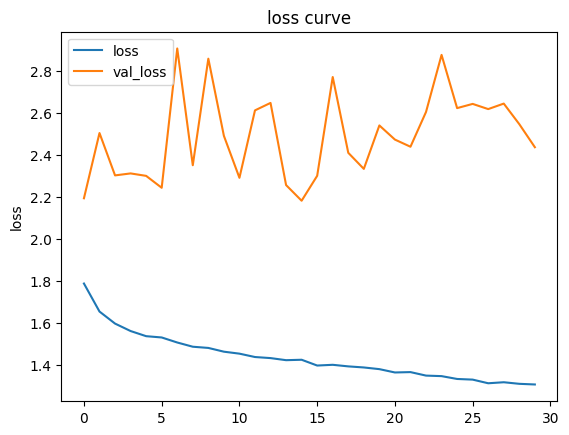

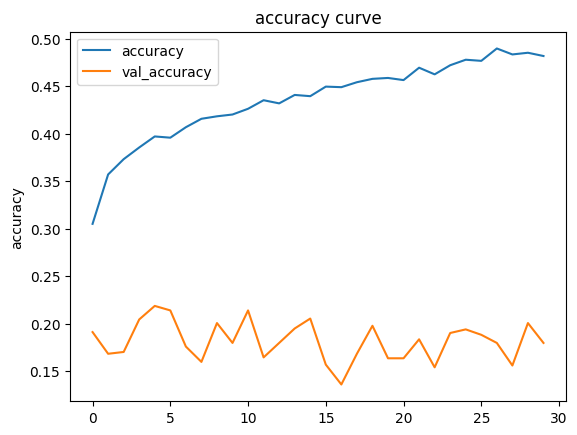

In [133]:
# 畫出 loss_curve、accuracy_curve
# 結果變差
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

33/33 [==============================] - 21s 597ms/step


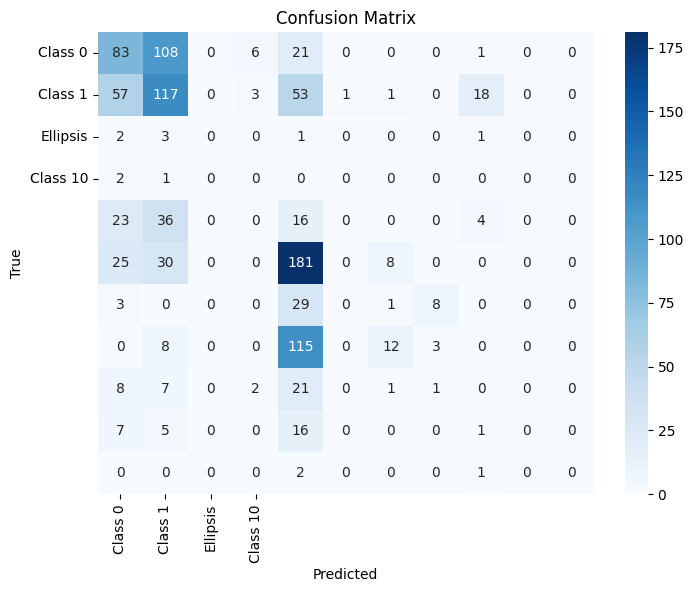

ValueError: ignored

In [135]:
# Prediction and evaluation
test_predictions = model.predict(test_generator)
predicted_labels = np.argmax(test_predictions, axis=1)

cm = confusion_matrix(test_generator.classes, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', ..., 'Class 10'], yticklabels=['Class 0', 'Class 1', ..., 'Class 10'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(test_generator.classes, predicted_labels, target_names=['Class 0', 'Class 1', ..., 'Class 11']))



## 第二題

### part1(LEAD_I)

#### 1.根據所被分配到的模型，外接CNN，並改變內部的參數(filter、padding、stride、pooling)，後面連接的分類器使用第一大題的結構(禁止修改)，accuracy需達80%以上


In [ ]:
# 讀取 LEAD_I 資料集
from google.colab import drive
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.optimizers import SGD

# Mount Google Drive
drive.mount('/content/drive')

# Access files "LEAD_I_output_classes_removed_border"
dataset_folder = '/content/drive/My Drive/Colab Notebooks/LEAD_I_output_classes_removed_border'

batch_size = 32
img_size = (180, 180)
img_shape = (180, 180, 3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 資料前處理
def preprocess_image(image_path):
    # Load image in grayscale and resize
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    img = np.expand_dims(img, axis=-1)  # Expand dimensions to make it (180, 180, 1)
    img = img / 255.0  # Normalize
    return img

# Custom data generator for grayscale images
class GrayImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def preprocess_image(self, image):
        return preprocess_image(image)

In [ ]:
# 產生 train_generator, validation_test_generator, validation_generator, test_generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    subset='training'
)

validation_test_generator = datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    subset='validation'
)

# Split the validation set into validation and test sets
validation_images, test_images, validation_labels, test_labels = train_test_split(
    validation_test_generator.filenames,
    validation_test_generator.labels,
    test_size=0.5,
    random_state=42
)

validation_df = pd.DataFrame({"filename": validation_images, "category": validation_labels.astype(str)})
test_df = pd.DataFrame({"filename": test_images, "category": test_labels.astype(str)})

validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    x_col="filename",
    y_col="category"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    x_col="filename",
    y_col="category"
)



Found 10259 images belonging to 11 classes.
Found 2560 images belonging to 11 classes.
Found 1280 validated image filenames belonging to 11 classes.
Found 1280 validated image filenames belonging to 11 classes.


In [ ]:
# 定義 model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define your CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(11, activation='softmax')
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 22, 22, 128)     

In [ ]:
# Compile model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
321/321 [==============================] - 77s 220ms/step - loss: 1.7139 - accuracy: 0.4196 - val_loss: 3.0603 - val_accuracy: 0.2531
Epoch 2/15
321/321 [==============================] - 71s 221ms/step - loss: 0.8653 - accuracy: 0.6950 - val_loss: 3.5128 - val_accuracy: 0.2281
Epoch 3/15
321/321 [==============================] - 70s 218ms/step - loss: 0.4903 - accuracy: 0.8268 - val_loss: 4.4464 - val_accuracy: 0.2344
Epoch 4/15
321/321 [==============================] - 70s 218ms/step - loss: 0.2691 - accuracy: 0.9057 - val_loss: 6.1162 - val_accuracy: 0.2188
Epoch 5/15
321/321 [==============================] - 70s 220ms/step - loss: 0.1422 - accuracy: 0.9530 - val_loss: 7.5515 - val_accuracy: 0.2219
Epoch 6/15
321/321 [==============================] - 72s 225ms/step - loss: 0.0898 - accuracy: 0.9705 - val_loss: 8.4849 - val_accuracy: 0.2391
Epoch 7/15
321/321 [==============================] - 73s 226ms/step - loss: 0.0505 - accuracy: 0.9857 - val_loss: 10.2991 - val_a

#### 2.根據第一小題的結果，使用兩種不同的optimizer，並比較哪一種對於辨識效果比較好

In [ ]:
## RMSprop, learning_rate=0.0015, 15個 epoch -> accuracy = 0.9994
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
321/321 [==============================] - 79s 243ms/step - loss: 2.5547 - accuracy: 0.2490 - val_loss: 2.6305 - val_accuracy: 0.2359
Epoch 2/15
321/321 [==============================] - 73s 227ms/step - loss: 1.2445 - accuracy: 0.5638 - val_loss: 2.8826 - val_accuracy: 0.2602
Epoch 3/15
321/321 [==============================] - 73s 227ms/step - loss: 0.7085 - accuracy: 0.7489 - val_loss: 3.9868 - val_accuracy: 0.2352
Epoch 4/15
321/321 [==============================] - 75s 232ms/step - loss: 0.3850 - accuracy: 0.8659 - val_loss: 3.9165 - val_accuracy: 0.2266
Epoch 5/15
321/321 [==============================] - 75s 235ms/step - loss: 0.1908 - accuracy: 0.9324 - val_loss: 5.7914 - val_accuracy: 0.2164
Epoch 6/15
321/321 [==============================] - 72s 224ms/step - loss: 0.0996 - accuracy: 0.9664 - val_loss: 7.9957 - val_accuracy: 0.2469
Epoch 7/15
321/321 [==============================] - 72s 224ms/step - loss: 0.0530 - accuracy: 0.9843 - val_loss: 10.0766 - val_a

In [ ]:
## SGD, learning_rate=0.0015, 15個 epoch -> accuracy = 0.5179
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
321/321 [==============================] - 81s 249ms/step - loss: 1.8962 - accuracy: 0.2351 - val_loss: 2.5281 - val_accuracy: 0.0562
Epoch 2/15
321/321 [==============================] - 81s 251ms/step - loss: 1.8788 - accuracy: 0.2541 - val_loss: 2.5413 - val_accuracy: 0.0562
Epoch 3/15
321/321 [==============================] - 78s 242ms/step - loss: 1.8736 - accuracy: 0.2606 - val_loss: 2.4247 - val_accuracy: 0.0562
Epoch 4/15
321/321 [==============================] - 71s 222ms/step - loss: 1.8669 - accuracy: 0.2680 - val_loss: 2.4290 - val_accuracy: 0.0656
Epoch 5/15
321/321 [==============================] - 75s 234ms/step - loss: 1.8597 - accuracy: 0.2817 - val_loss: 2.4810 - val_accuracy: 0.1422
Epoch 6/15
321/321 [==============================] - 72s 223ms/step - loss: 1.8485 - accuracy: 0.2987 - val_loss: 2.4588 - val_accuracy: 0.0562
Epoch 7/15
321/321 [==============================] - 73s 228ms/step - loss: 1.8341 - accuracy: 0.3237 - val_loss: 2.4635 - val_ac

#### 3.根據第二小題的架構，取用較好結果的優化器，並且改變learning_rate，比較哪個數值對於辨識效果比較好

In [ ]:
## RMSprop, Learning_rate = 0.1 -> accuracy = 0.2409
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
321/321 [==============================] - 73s 223ms/step - loss: 2413510.0000 - accuracy: 0.2332 - val_loss: 2.4534 - val_accuracy: 0.0562
Epoch 2/15
321/321 [==============================] - 76s 238ms/step - loss: 1.8874 - accuracy: 0.2422 - val_loss: 2.4718 - val_accuracy: 0.0562
Epoch 3/15
321/321 [==============================] - 72s 224ms/step - loss: 1.8868 - accuracy: 0.2438 - val_loss: 2.4302 - val_accuracy: 0.0562
Epoch 4/15
321/321 [==============================] - 73s 227ms/step - loss: 1.8880 - accuracy: 0.2459 - val_loss: 2.5005 - val_accuracy: 0.0562
Epoch 5/15
321/321 [==============================] - 74s 230ms/step - loss: 1.8864 - accuracy: 0.2444 - val_loss: 2.4471 - val_accuracy: 0.1937
Epoch 6/15
321/321 [==============================] - 73s 228ms/step - loss: 1.8863 - accuracy: 0.2449 - val_loss: 2.4866 - val_accuracy: 0.0562
Epoch 7/15
321/321 [==============================] - 75s 232ms/step - loss: 1.8862 - accuracy: 0.2431 - val_loss: 2.5253 - 

In [ ]:
## RMSprop, Learning_rate = 0.01 -> accuracy = 0.2545

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
321/321 [==============================] - 76s 233ms/step - loss: 67.7387 - accuracy: 0.2395 - val_loss: 2.4144 - val_accuracy: 0.0562
Epoch 2/15
321/321 [==============================] - 71s 222ms/step - loss: 1.8825 - accuracy: 0.2486 - val_loss: 2.5080 - val_accuracy: 0.0562
Epoch 3/15
321/321 [==============================] - 75s 234ms/step - loss: 1.8800 - accuracy: 0.2526 - val_loss: 2.5000 - val_accuracy: 0.0562
Epoch 4/15
321/321 [==============================] - 71s 223ms/step - loss: 1.8781 - accuracy: 0.2539 - val_loss: 2.4215 - val_accuracy: 0.0562
Epoch 5/15
321/321 [==============================] - 71s 222ms/step - loss: 1.8780 - accuracy: 0.2545 - val_loss: 2.6367 - val_accuracy: 0.0562
Epoch 6/15
321/321 [==============================] - 71s 222ms/step - loss: 1.8779 - accuracy: 0.2538 - val_loss: 2.3550 - val_accuracy: 0.0562
Epoch 7/15
321/321 [==============================] - 72s 223ms/step - loss: 1.8779 - accuracy: 0.2545 - val_loss: 2.4258 - val_a

In [ ]:
## RMSprop, Learning_rate = 0.001 -> accuracy = 0.9996

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
321/321 [==============================] - 74s 227ms/step - loss: 1.7973 - accuracy: 0.4266 - val_loss: 2.7561 - val_accuracy: 0.2562
Epoch 2/15
321/321 [==============================] - 71s 221ms/step - loss: 0.8441 - accuracy: 0.7045 - val_loss: 4.1449 - val_accuracy: 0.2648
Epoch 3/15
321/321 [==============================] - 71s 222ms/step - loss: 0.4594 - accuracy: 0.8387 - val_loss: 4.5337 - val_accuracy: 0.2422
Epoch 4/15
321/321 [==============================] - 72s 224ms/step - loss: 0.2388 - accuracy: 0.9192 - val_loss: 5.3023 - val_accuracy: 0.2148
Epoch 5/15
321/321 [==============================] - 71s 221ms/step - loss: 0.1185 - accuracy: 0.9598 - val_loss: 7.1734 - val_accuracy: 0.2711
Epoch 6/15
321/321 [==============================] - 73s 229ms/step - loss: 0.0632 - accuracy: 0.9793 - val_loss: 9.4388 - val_accuracy: 0.2461
Epoch 7/15
321/321 [==============================] - 71s 222ms/step - loss: 0.0352 - accuracy: 0.9896 - val_loss: 9.5122 - val_ac

In [ ]:
## RMSprop, Learning_rate = 0.0001 -> accuracy = 0.9897

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
321/321 [==============================] - 76s 235ms/step - loss: 1.7469 - accuracy: 0.3607 - val_loss: 2.4431 - val_accuracy: 0.2711
Epoch 2/15
321/321 [==============================] - 74s 231ms/step - loss: 1.2242 - accuracy: 0.5707 - val_loss: 2.6655 - val_accuracy: 0.2516
Epoch 3/15
321/321 [==============================] - 72s 223ms/step - loss: 0.9748 - accuracy: 0.6574 - val_loss: 2.8253 - val_accuracy: 0.2492
Epoch 4/15
321/321 [==============================] - 72s 224ms/step - loss: 0.7660 - accuracy: 0.7276 - val_loss: 3.6916 - val_accuracy: 0.2570
Epoch 5/15
321/321 [==============================] - 74s 232ms/step - loss: 0.5986 - accuracy: 0.7881 - val_loss: 3.4834 - val_accuracy: 0.2617
Epoch 6/15
321/321 [==============================] - 73s 228ms/step - loss: 0.4663 - accuracy: 0.8369 - val_loss: 4.2013 - val_accuracy: 0.2492
Epoch 7/15
321/321 [==============================] - 73s 229ms/step - loss: 0.3610 - accuracy: 0.8759 - val_loss: 4.5994 - val_ac

#### 4.根據以上的小題，將較好的結果畫出loss_curve、accuracy_curve、confusion_matrix及Classification_report

In [ ]:
# 讀取 LEAD_I 資料集

from google.colab import drive
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.optimizers import SGD

# Mount Google Drive
drive.mount('/content/drive')

# Access files "LEAD_I_output_classes_removed_border"
dataset_folder = '/content/drive/My Drive/Colab Notebooks/LEAD_I_output_classes_removed_border'

batch_size = 32
img_size = (180, 180)
img_shape = (180, 180, 3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 資料前處理

def preprocess_image(image_path):
    # Load image in grayscale and resize
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    img = np.expand_dims(img, axis=-1)  # Expand dimensions to make it (180, 180, 1)
    img = img / 255.0  # Normalize
    return img

# Custom data generator for grayscale images
class GrayImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def preprocess_image(self, image):
        return preprocess_image(image)

In [ ]:
# 產生 train_generator, validation_test_generator, validation_generator, test_generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    subset='training'
)

validation_test_generator = datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    subset='validation'
)

# Split the validation set into validation and test sets
validation_images, test_images, validation_labels, test_labels = train_test_split(
    validation_test_generator.filenames,
    validation_test_generator.labels,
    test_size=0.5,
    random_state=42
)

validation_df = pd.DataFrame({"filename": validation_images, "category": validation_labels.astype(str)})
test_df = pd.DataFrame({"filename": test_images, "category": test_labels.astype(str)})

validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    x_col="filename",
    y_col="category"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    x_col="filename",
    y_col="category"
)

Found 10259 images belonging to 11 classes.
Found 2560 images belonging to 11 classes.
Found 1280 validated image filenames belonging to 11 classes.
Found 1280 validated image filenames belonging to 11 classes.


In [ ]:
# 定義 model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define your CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(11, activation='softmax')
])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 22, 22, 128)     

In [ ]:
## RMSprop, Learning_rate = 0.001 -> accuracy = 0.9989

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
321/321 [==============================] - 76s 231ms/step - loss: 1.7462 - accuracy: 0.3881 - val_loss: 3.0474 - val_accuracy: 0.2758
Epoch 2/15
321/321 [==============================] - 72s 225ms/step - loss: 0.8918 - accuracy: 0.6886 - val_loss: 3.5774 - val_accuracy: 0.2555
Epoch 3/15
321/321 [==============================] - 73s 226ms/step - loss: 0.4880 - accuracy: 0.8266 - val_loss: 5.7041 - val_accuracy: 0.2109
Epoch 4/15
321/321 [==============================] - 69s 215ms/step - loss: 0.2671 - accuracy: 0.9059 - val_loss: 5.8059 - val_accuracy: 0.2539
Epoch 5/15
321/321 [==============================] - 70s 217ms/step - loss: 0.1293 - accuracy: 0.9563 - val_loss: 7.0919 - val_accuracy: 0.2414
Epoch 6/15
321/321 [==============================] - 72s 224ms/step - loss: 0.0760 - accuracy: 0.9772 - val_loss: 7.6023 - val_accuracy: 0.2250
Epoch 7/15
321/321 [==============================] - 72s 224ms/step - loss: 0.0477 - accuracy: 0.9848 - val_loss: 8.4497 - val_ac

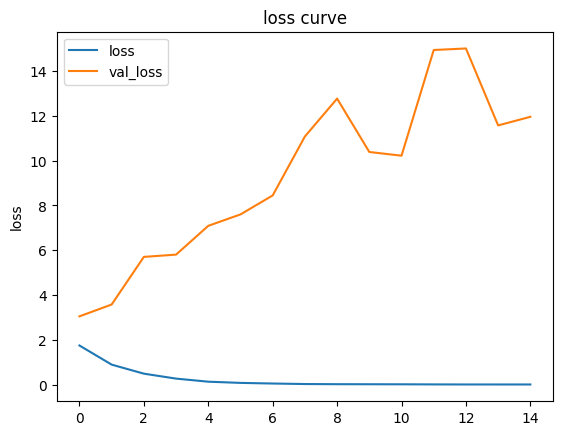

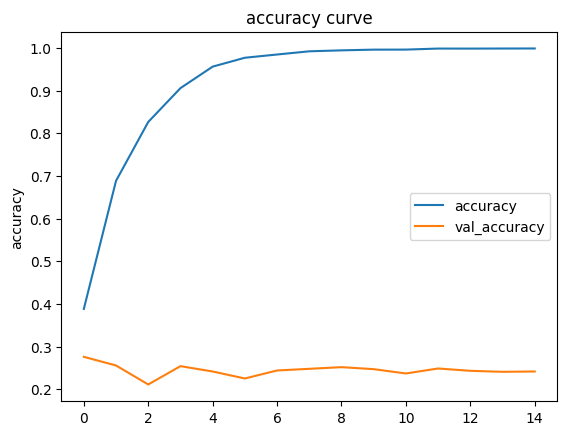

In [ ]:
# 畫出 loss_curve、accuracy_curve
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

40/40 [==============================] - 423s 11s/step


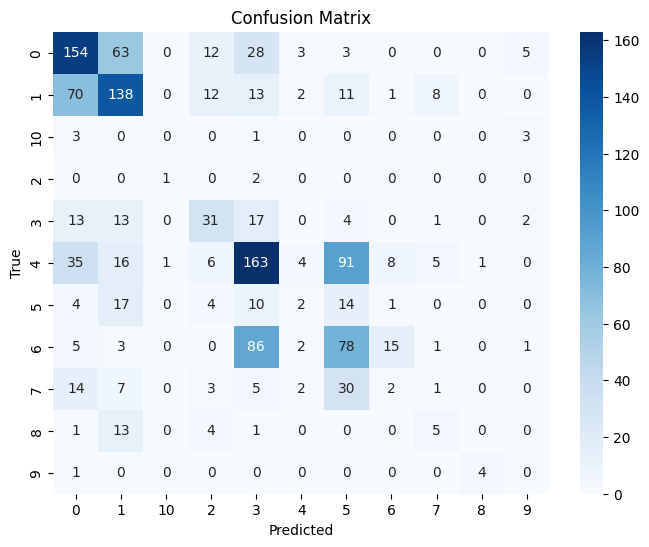

              precision    recall  f1-score   support

           0       0.51      0.57      0.54       268
           1       0.51      0.54      0.53       255
          10       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         3
           3       0.05      0.21      0.08        81
           4       0.27      0.01      0.02       330
           5       0.06      0.27      0.10        52
           6       0.56      0.08      0.14       191
           7       0.05      0.02      0.02        64
           8       0.00      0.00      0.00        24
           9       0.00      0.00      0.00         5

    accuracy                           0.27      1280
   macro avg       0.18      0.15      0.13      1280
weighted avg       0.37      0.27      0.26      1280



In [ ]:
# 畫出 confusion_matrix及Classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Predict test set
test_predictions = model.predict(test_generator)
# Convert predictions to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices))



#### 5.(加分題)嘗試data_augmentation，比較結果是否變差或變好

In [136]:
# 讀取 LEAD_I 資料集

from google.colab import drive
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.optimizers import SGD

# Mount Google Drive
drive.mount('/content/drive')

# Access files "LEAD_I_output_classes_removed_border"
dataset_folder = '/content/drive/My Drive/Colab Notebooks/LEAD_I_output_classes_removed_border'

batch_size = 32
img_size = (180, 180)
img_shape = (180, 180, 3)



def preprocess_image(image_path):
    # Load image in grayscale and resize
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    img = np.expand_dims(img, axis=-1)  # Expand dimensions to make it (180, 180, 1)
    img = img / 255.0  # Normalize
    return img

# Custom data generator for grayscale images
class GrayImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def preprocess_image(self, image):
        return preprocess_image(image)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
# 資料前處理

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Degree range for random rotations
    width_shift_range=0.2,  # Fraction of total width for random horizontal shifts
    height_shift_range=0.2,  # Fraction of total height for random vertical shifts
    shear_range=0.2,  # Shear angle in counter-clockwise direction
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    validation_split=0.2
)

# Create a data generator for training with augmentation
train_generator = train_datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    subset='training'
)

# Data generators for validation and test sets
validation_test_generator = train_datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    subset='validation'
)


# Split the validation set into validation and test sets
validation_images, test_images, validation_labels, test_labels = train_test_split(
    validation_test_generator.filenames,
    validation_test_generator.labels,
    test_size=0.5,
    random_state=42
)

validation_df = pd.DataFrame({"filename": validation_images, "category": validation_labels.astype(str)})
test_df = pd.DataFrame({"filename": test_images, "category": test_labels.astype(str)})

validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    x_col="filename",
    y_col="category"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    x_col="filename",
    y_col="category"
)

Found 10259 images belonging to 11 classes.
Found 2560 images belonging to 11 classes.
Found 1280 validated image filenames belonging to 11 classes.
Found 1280 validated image filenames belonging to 11 classes.


In [138]:
# 加入 CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define your CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(11, activation='softmax')
])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_61 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 22, 22, 128)     

In [139]:
# Compile model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [140]:
epochs = 30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/30
321/321 [==============================] - 153s 469ms/step - loss: 2.0599 - accuracy: 0.2414 - val_loss: 2.3983 - val_accuracy: 0.0562
Epoch 2/30
321/321 [==============================] - 147s 459ms/step - loss: 1.8856 - accuracy: 0.2511 - val_loss: 2.5013 - val_accuracy: 0.0562
Epoch 3/30
321/321 [==============================] - 147s 458ms/step - loss: 1.8740 - accuracy: 0.2759 - val_loss: 2.4326 - val_accuracy: 0.1406
Epoch 4/30
321/321 [==============================] - 150s 466ms/step - loss: 1.8498 - accuracy: 0.2973 - val_loss: 2.4877 - val_accuracy: 0.1484
Epoch 5/30
321/321 [==============================] - 148s 462ms/step - loss: 1.8284 - accuracy: 0.3117 - val_loss: 2.5539 - val_accuracy: 0.1516
Epoch 6/30
321/321 [==============================] - 147s 459ms/step - loss: 1.7853 - accuracy: 0.3337 - val_loss: 2.4572 - val_accuracy: 0.2164
Epoch 7/30
321/321 [==============================] - 149s 465ms/step - loss: 1.7431 - accuracy: 0.3531 - val_loss: 2.8358 -

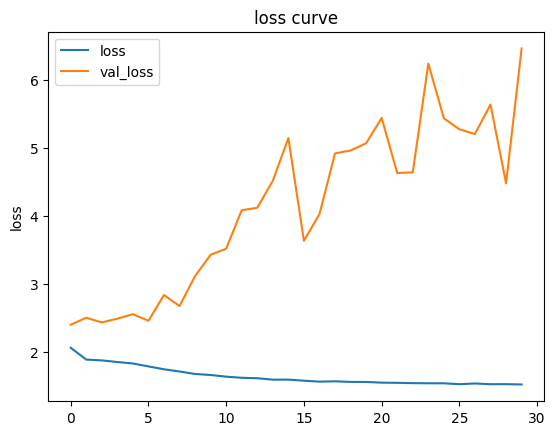

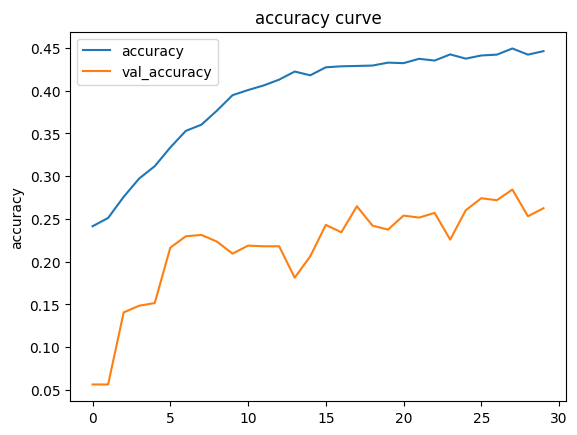

In [141]:
# 畫出 loss_curve、accuracy_curve
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

40/40 [==============================] - 13s 323ms/step


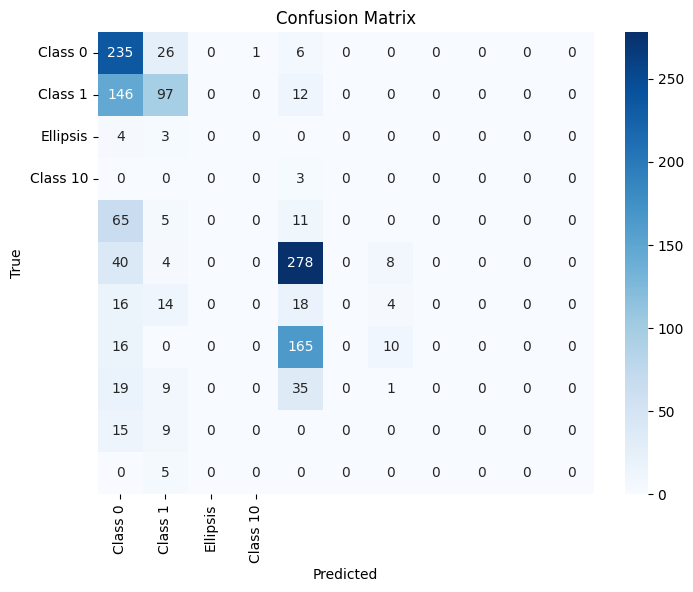

ValueError: ignored

In [142]:
# 畫出 confusion_matrix及Classification_report
# Prediction and evaluation
test_predictions = model.predict(test_generator)
predicted_labels = np.argmax(test_predictions, axis=1)

cm = confusion_matrix(test_generator.classes, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', ..., 'Class 10'], yticklabels=['Class 0', 'Class 1', ..., 'Class 10'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(test_generator.classes, predicted_labels, target_names=['Class 0', 'Class 1', ..., 'Class 10']))



### part2(被分配到的第二個導程)

#### 1.根據所被分配到的模型，以part1第一小題的架構，訓練被分配到的另一個導程資料集

In [108]:
# 讀取 LEAD_aVF 資料集
from google.colab import drive
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.optimizers import SGD

# Mount Google Drive
drive.mount('/content/drive')

# Access files "LEAD_I_output_classes_removed_border"
dataset_folder = '/content/drive/My Drive/Colab Notebooks/LEAD_aVF_output_classes_removed_border'

batch_size = 32
img_size = (180, 180)
img_shape = (180, 180, 3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
# 資料前處理
def preprocess_image(image_path):
    # Load image in grayscale and resize
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    img = np.expand_dims(img, axis=-1)  # Expand dimensions to make it (180, 180, 1)
    img = img / 255.0  # Normalize
    return img

# Custom data generator for grayscale images
class GrayImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def preprocess_image(self, image):
        return preprocess_image(image)

In [110]:
# 產生 train_generator, validation_test_generator, validation_generator, test_generator
from sklearn.model_selection import train_test_split
import os

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Use flow_from_directory to load images directly from folders
train_generator = datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    subset='validation'
)

# Combine validation and test sets for further splitting
validation_test_images = validation_generator.filenames
validation_test_labels = validation_generator.classes

# Split the combined validation and test sets into separate sets
validation_images, test_images, validation_labels, test_labels = train_test_split(
    validation_test_images,
    validation_test_labels,
    test_size=0.5,
    random_state=42,
    stratify=validation_test_labels  # Ensures proportionate splitting of classes
)

# Create dataframes for validation and test sets
validation_df = pd.DataFrame({"filename": validation_images, "category": validation_labels.astype(str)})
test_df = pd.DataFrame({"filename": test_images, "category": test_labels.astype(str)})

# Create generators for validation and test sets from dataframes
validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    x_col="filename",
    y_col="category"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    x_col="filename",
    y_col="category"
)


Found 8446 images belonging to 11 classes.
Found 2105 images belonging to 11 classes.
Found 1052 validated image filenames belonging to 11 classes.
Found 1053 validated image filenames belonging to 11 classes.


In [111]:
# 定義 model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define your CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(11, activation='softmax')
])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 22, 22, 128)     

In [95]:
# Compile model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [96]:

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
264/264 [==============================] - 86s 299ms/step - loss: 2.1480 - accuracy: 0.2504 - val_loss: 2.3242 - val_accuracy: 0.0875
Epoch 2/15
264/264 [==============================] - 59s 225ms/step - loss: 1.2434 - accuracy: 0.5141 - val_loss: 3.9839 - val_accuracy: 0.1816
Epoch 3/15
264/264 [==============================] - 58s 221ms/step - loss: 0.5901 - accuracy: 0.7722 - val_loss: 4.6962 - val_accuracy: 0.1797
Epoch 4/15
264/264 [==============================] - 58s 220ms/step - loss: 0.2769 - accuracy: 0.8963 - val_loss: 7.2717 - val_accuracy: 0.2034
Epoch 5/15
264/264 [==============================] - 59s 223ms/step - loss: 0.1436 - accuracy: 0.9497 - val_loss: 7.3146 - val_accuracy: 0.1930
Epoch 6/15
264/264 [==============================] - 58s 219ms/step - loss: 0.0806 - accuracy: 0.9729 - val_loss: 9.1166 - val_accuracy: 0.1930
Epoch 7/15
264/264 [==============================] - 59s 223ms/step - loss: 0.0571 - accuracy: 0.9806 - val_loss: 9.8957 - val_ac

#### 2.使用與part1相同的兩個optimizer比較哪一種對於辨識效果比較好

In [102]:
## RMSprop, learning_rate=0.0015, 15個 epoch -> accuracy = 0.9980
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
264/264 [==============================] - 65s 243ms/step - loss: 1.9515 - accuracy: 0.4117 - val_loss: 3.5418 - val_accuracy: 0.2139
Epoch 2/15
264/264 [==============================] - 58s 219ms/step - loss: 0.6876 - accuracy: 0.7399 - val_loss: 6.1542 - val_accuracy: 0.1873
Epoch 3/15
264/264 [==============================] - 58s 218ms/step - loss: 0.3284 - accuracy: 0.8812 - val_loss: 7.4362 - val_accuracy: 0.2167
Epoch 4/15
264/264 [==============================] - 57s 216ms/step - loss: 0.1714 - accuracy: 0.9407 - val_loss: 7.5651 - val_accuracy: 0.2025
Epoch 5/15
264/264 [==============================] - 65s 245ms/step - loss: 0.1011 - accuracy: 0.9674 - val_loss: 7.7713 - val_accuracy: 0.2281
Epoch 6/15
264/264 [==============================] - 60s 228ms/step - loss: 0.0617 - accuracy: 0.9802 - val_loss: 9.3281 - val_accuracy: 0.2091
Epoch 7/15
264/264 [==============================] - 58s 218ms/step - loss: 0.0388 - accuracy: 0.9882 - val_loss: 12.0950 - val_a

In [107]:
## SGD, learning_rate=0.0015, 15個 epoch -> accuracy = 0.4941
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
264/264 [==============================] - 59s 220ms/step - loss: 1.9249 - accuracy: 0.2341 - val_loss: 2.4171 - val_accuracy: 0.2376
Epoch 2/15
264/264 [==============================] - 57s 217ms/step - loss: 1.8945 - accuracy: 0.2345 - val_loss: 2.4183 - val_accuracy: 0.0741
Epoch 3/15
264/264 [==============================] - 57s 214ms/step - loss: 1.8927 - accuracy: 0.2434 - val_loss: 2.4124 - val_accuracy: 0.0741
Epoch 4/15
264/264 [==============================] - 57s 217ms/step - loss: 1.8885 - accuracy: 0.2501 - val_loss: 2.3677 - val_accuracy: 0.2376
Epoch 5/15
264/264 [==============================] - 60s 227ms/step - loss: 1.8834 - accuracy: 0.2647 - val_loss: 2.3999 - val_accuracy: 0.2072
Epoch 6/15
264/264 [==============================] - 58s 218ms/step - loss: 1.8759 - accuracy: 0.2727 - val_loss: 2.3623 - val_accuracy: 0.2291
Epoch 7/15
264/264 [==============================] - 57s 218ms/step - loss: 1.8688 - accuracy: 0.3013 - val_loss: 2.4398 - val_ac

#### 3.使用與part1第三小題一樣的optimizer及learning_rate，並畫出loss_curve、accuracy_curve、confusion_matrix及Classification_report

In [112]:
## RMSprop, learning_rate=0.0015, 15個 epoch -> accuracy = 0.9976
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
264/264 [==============================] - 65s 240ms/step - loss: 2.6128 - accuracy: 0.3081 - val_loss: 3.2482 - val_accuracy: 0.2053
Epoch 2/15
264/264 [==============================] - 60s 226ms/step - loss: 0.8969 - accuracy: 0.6540 - val_loss: 4.9526 - val_accuracy: 0.2091
Epoch 3/15
264/264 [==============================] - 65s 245ms/step - loss: 0.4315 - accuracy: 0.8428 - val_loss: 6.3277 - val_accuracy: 0.2034
Epoch 4/15
264/264 [==============================] - 58s 221ms/step - loss: 0.2299 - accuracy: 0.9169 - val_loss: 7.6666 - val_accuracy: 0.1882
Epoch 5/15
264/264 [==============================] - 59s 223ms/step - loss: 0.1233 - accuracy: 0.9600 - val_loss: 6.9988 - val_accuracy: 0.2053
Epoch 6/15
264/264 [==============================] - 57s 218ms/step - loss: 0.0847 - accuracy: 0.9705 - val_loss: 9.1941 - val_accuracy: 0.2158
Epoch 7/15
264/264 [==============================] - 57s 217ms/step - loss: 0.0511 - accuracy: 0.9841 - val_loss: 9.2079 - val_ac

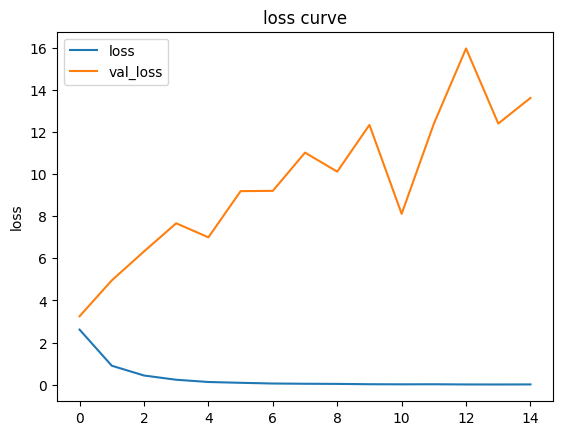

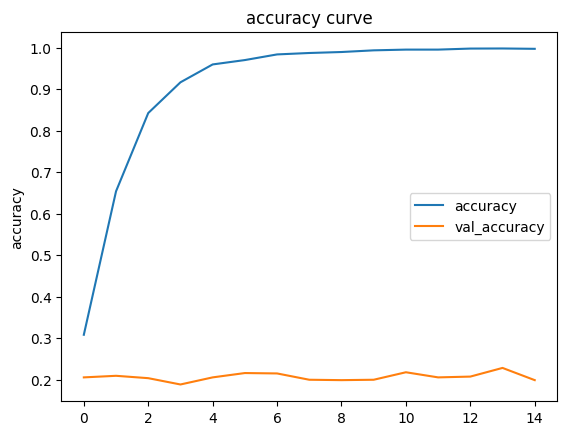

In [113]:
# 畫出 loss_curve、accuracy_curve
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()


33/33 [==============================] - 327s 10s/step


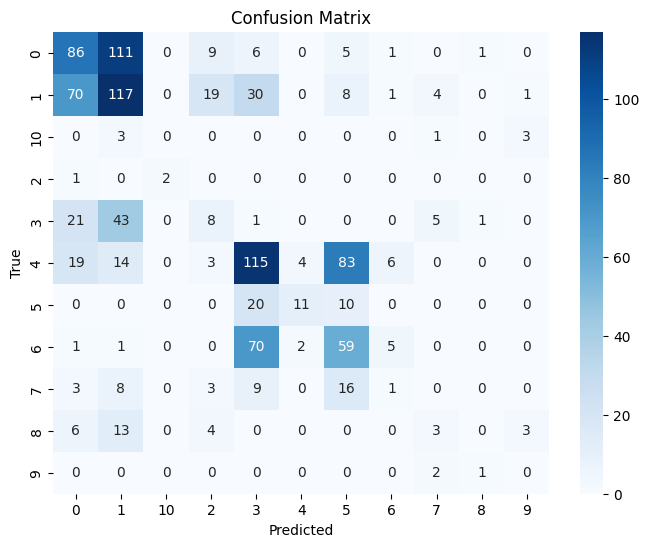

              precision    recall  f1-score   support

           0       0.42      0.39      0.40       219
           1       0.38      0.47      0.42       250
          10       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         3
           3       0.00      0.01      0.01        79
           4       0.24      0.02      0.03       244
           5       0.06      0.24      0.09        41
           6       0.36      0.04      0.07       138
           7       0.00      0.00      0.00        40
           8       0.00      0.00      0.00        29
           9       0.00      0.00      0.00         3

    accuracy                           0.21      1053
   macro avg       0.13      0.11      0.09      1053
weighted avg       0.28      0.21      0.20      1053



In [114]:
# 畫出 confusion_matrix及Classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Predict test set
test_predictions = model.predict(test_generator)
# Convert predictions to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices))



#### 4.(加分題)嘗試data_augmentation，比較結果是否變差或變好

In [115]:
# 讀取 LEAD_aVF 資料集
from google.colab import drive
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Mount Google Drive
drive.mount('/content/drive')

# Access files
dataset_folder = '/content/drive/My Drive/Colab Notebooks/LEAD_aVF_output_classes_removed_border'

batch_size = 32
img_size = (180, 180)
img_shape = (180, 180, 3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
# 資料前處理 + data augmentation
# 產生 train_generator, validation_test_generator, validation_generator, test_generator
from sklearn.model_selection import train_test_split

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Degree range for random rotations
    width_shift_range=0.2,  # Fraction of total width for random horizontal shifts
    height_shift_range=0.2,  # Fraction of total height for random vertical shifts
    shear_range=0.2,  # Shear angle in counter-clockwise direction
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    validation_split=0.2
)

# Create a data generator for training with augmentation
train_generator = train_datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    subset='training'
)

# Data generators for validation and test sets
validation_test_generator = train_datagen.flow_from_directory(
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    subset='validation'
)

# Combine validation and test sets for further splitting
validation_test_images = validation_test_generator.filenames
validation_test_labels = validation_test_generator.classes

# Split the combined validation and test sets into separate sets
validation_images, test_images, validation_labels, test_labels = train_test_split(
    validation_test_images,
    validation_test_labels,
    test_size=0.5,
    random_state=42,
    stratify=validation_test_labels  # Ensures proportionate splitting of classes
)

# Create dataframes for validation and test sets
validation_df = pd.DataFrame({"filename": validation_images, "category": validation_labels.astype(str)})
test_df = pd.DataFrame({"filename": test_images, "category": test_labels.astype(str)})

# Create generators for validation and test sets from dataframes
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=True,
    x_col="filename",
    y_col="category"
)

test_generator = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=42,
    shuffle=False,
    x_col="filename",
    y_col="category"
)


Found 8446 images belonging to 11 classes.
Found 2105 images belonging to 11 classes.
Found 1052 validated image filenames belonging to 11 classes.
Found 1053 validated image filenames belonging to 11 classes.


In [118]:
# 定義 model
# Model architecture setup and compilation
vgg16_base = tf.keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

x = vgg16_base.output
x = layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = layers.Dense(units=11, activation='softmax')(x)

model = tf.keras.Model(inputs=vgg16_base.input, outputs=output_layer)

for layer in vgg16_base.layers:
    layer.trainable = False

In [119]:
# Compile model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [120]:
epochs = 15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/15
264/264 [==============================] - 144s 524ms/step - loss: 1.8236 - accuracy: 0.2942 - val_loss: 2.4771 - val_accuracy: 0.1930
Epoch 2/15
264/264 [==============================] - 129s 488ms/step - loss: 1.6586 - accuracy: 0.3576 - val_loss: 2.4857 - val_accuracy: 0.1749
Epoch 3/15
264/264 [==============================] - 131s 495ms/step - loss: 1.6086 - accuracy: 0.3692 - val_loss: 2.4377 - val_accuracy: 0.1958
Epoch 4/15
264/264 [==============================] - 132s 501ms/step - loss: 1.5639 - accuracy: 0.3853 - val_loss: 2.2900 - val_accuracy: 0.1816
Epoch 5/15
264/264 [==============================] - 129s 488ms/step - loss: 1.5367 - accuracy: 0.3925 - val_loss: 2.6512 - val_accuracy: 0.1597
Epoch 6/15
264/264 [==============================] - 129s 489ms/step - loss: 1.5320 - accuracy: 0.4013 - val_loss: 2.4603 - val_accuracy: 0.1892
Epoch 7/15
264/264 [==============================] - 131s 495ms/step - loss: 1.5022 - accuracy: 0.4093 - val_loss: 2.4302 -

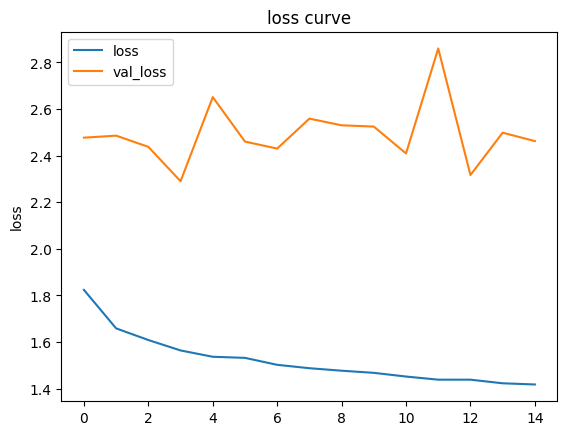

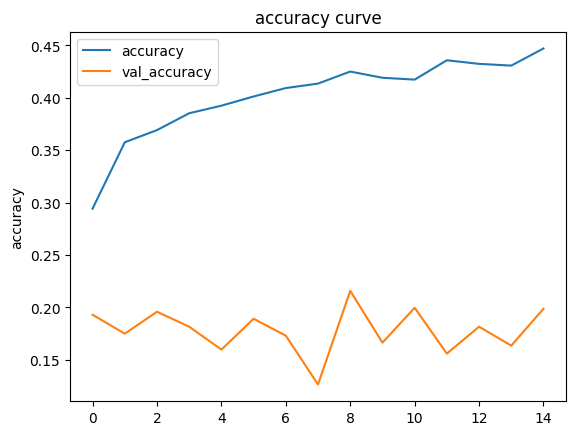

In [121]:
# 畫出 loss_curve、accuracy_curve
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()



33/33 [==============================] - 19s 571ms/step


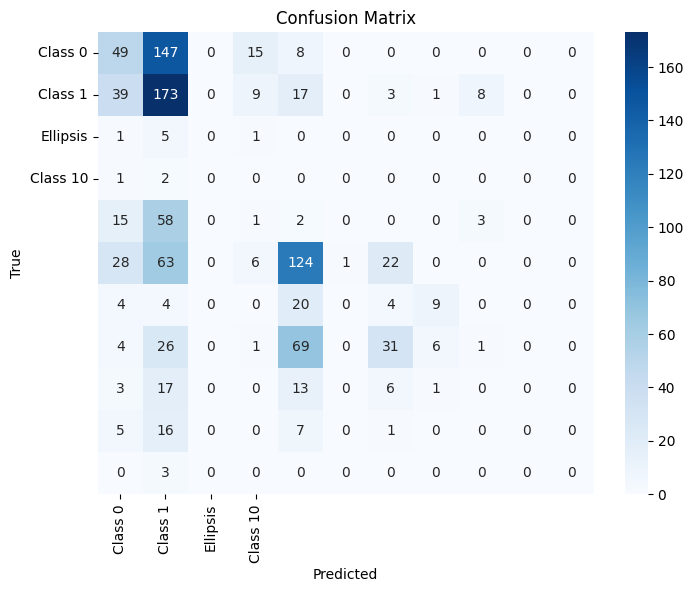

ValueError: ignored

In [122]:
# 畫出 confusion_matrix及Classification_report
# Prediction and evaluation
test_predictions = model.predict(test_generator)
predicted_labels = np.argmax(test_predictions, axis=1)

cm = confusion_matrix(test_generator.classes, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', ..., 'Class 10'], yticklabels=['Class 0', 'Class 1', ..., 'Class 10'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(test_generator.classes, predicted_labels, target_names=['Class 0', 'Class 1', ..., 'Class 10']))



結果變差

## 第三題

### 心得part1

#### 觀察第一大題的結果，比較模型架構對兩個導程辨識的效果(調整哪些參數對辨識結果影響較大)


<br>1.1: 
<br>Adam, learning_rate=0.0015, 75 個 epoch -> accuracy = 0.4428
<br>RMSprop, learning_rate=0.0015, 15 個 epoch -> accuracy = 0.6091
<br>SGD, learning_rate=0.0015, 15個 epoch -> accuracy = 0.3662
<br>
<br>-> "RMSprop" 架構的辨識準確率最高
<br>
<br>1.2:
<br>RMSprop, Learning_rate = 0.1 -> accuracy = 0.2394
<br>RMSprop, Learning_rate = 0.01 -> accuracy: 0.5900
<br>RMSprop, Learning_rate = 0.001 -> accuracy: 0.6881
<br>RMSprop, Learning_rate = 0.0001 -> accuracy: 0.5490
<br>
<br>-> "Learning_rate = 0.001" 時, accuracy 最高
<br>
<br>2.1:
<br>Adam, learning_rate=0.0015, 20 個 epoch -> accuracy < 0.5749
<br>RMSprop, learning_rate=0.0015, 15個 epoch -> accuracy = 0.6033
<br>SGD, learning_rate=0.0015, 15個 epoch -> accuracy = 0.3678
<br>
<br>-> "RMSprop" 架構的辨識準確率最高
<br>
<br>但 Data Augmentation 後結果未變好, 推測可能原因：
<br>Over-augmentation
<br>Inappropriate Augmentation Techniques
<br>Incorrect Implementation
<br>
<br>
<br>結論：調整模型種類和選取合適的 Learning rate 對於辨識結果有顯著影響。
<br>

### 心得part2

#### 觀察第二大題的結果，比較模型架構對兩個導程辨識的效果(調整哪些參數對辨識結果影響較大)

<br>外接CNN，並改變內部的參數(filter、padding、stride、pooling)
<br>
<br>filter 改變
<br>padding='same'
<br>MaxPooling2D(pool_size=(2, 2)),
<br>
<br>
<br>1.1: 
<br>Adam, learning_rate=0.0015, 15 個 epoch -> accuracy = 0.9981
<br>RMSprop, learning_rate=0.0015, 15個 epoch -> accuracy = 0.9994
<br>SGD, learning_rate=0.0015, 15個 epoch -> accuracy = 0.5179
<br>
<br>-> "RMSprop" 架構的辨識準確率最高
<br>
<br>1.2:
<br>RMSprop, Learning_rate = 0.1 -> accuracy = 0.2409
<br>RMSprop, Learning_rate = 0.01 -> accuracy = 0.2545
<br>RMSprop, Learning_rate = 0.001 -> accuracy = 0.9996
<br>RMSprop, Learning_rate = 0.0001 -> accuracy = 0.9897
<br>
<br>-> "Learning_rate = 0.001" 時, accuracy 最高
<br>
<br>2.1:
<br>Adam, learning_rate=0.0015, 15 個 epoch -> accuracy = 0.9950
<br>RMSprop, learning_rate=0.0015, 15個 epoch -> accuracy = 0.9980
<br>SGD, learning_rate=0.0015, 15個 epoch -> accuracy = 0.4941
<br>
<br>-> "RMSprop" 架構的辨識準確率最高
<br>
<br>
<br>結論：加上 CNN 後若選取適合的調整模型種類和 Learning rate, 則辨識準確率能快速達到 0.9 以上。